## Two-dimensional phase-field model (Allen-Cahn equation)
This python code was developed by Yamanaka research group of Tokyo University of Agriculture and Technology in August 2019.

## Problem
Let us consider an example: growth of phase B in phase A. 
This notebook shows two-dimensional phase-field simulation of the growth of phase B using Allen-Cahn equation. 

For details of the model, please see reference (*S. M. Allen and J. W. Cahn, "A Microscopic Theory for Antiphase Boundary Motion and Its Application to Antiphase Domain Coarsening," Acta Metallurgica, Vol. 27 (1979), pp. 1085–1095.*).
## Formulation
### 1. Order parameter
An non-conserved order parameter $\phi$ (hereafter, we call it as "phase-field variable".) is used. The phase-field variable $\phi$ is defined as $\phi = 0$ in phase A and $\phi = 1$ in phase B. The phase-field variable $\phi$ smoothly changes from 0 to 1 in an "diffuse" interfacial region. 
### 2. Total free energy
The total Gibbs free energy of the system is defined by
$$
G = \int_{V} (g_{chem}(\phi) + g_{doub}(\phi) + g_{grad}(\nabla\phi)) dV
$$
where, $g_{chem}$, $g_{doub}$, and $g_{grad}$ are the chemical free energy, the double-well potential energy and the gradient energy densities, respectively. In this source code, these energy densities are defined as follows: 
$$
g_{chem} = p(\phi)g_{B} + (1-p(\phi))g_{A}
$$
$$
g_{doub} = Wq(\phi)
$$
$$
g_{grad} = \frac{a^{2}}{2}|\nabla\phi|^{2}
$$
where $g_{A}$ and $g_{B}$ are Gibbs free energy densities of pure phase A and pure phase B, respectively. Here, $g_{A}$ and $g_{B}$ are assumed to be constant. 

$p(\phi)$ and $q(\phi)$ are an interpolation function and the double-well potential function. These functions are often defined as follows: 
$$
p(\phi) = \phi^{2}(3-2\phi)
$$
$$
q(\phi) = \phi^{2}(1-\phi)^{2}
$$

$W$ and $a$ are the height of double-well potential energy and the gradient energy coefficient, respectively, which are given by
$$
W = \frac{6\sigma\delta}{b}
$$
$$
a = \sqrt{\frac{3\sigma b}{\delta}}
$$
where $\sigma$ is the interfacial energy of an interface between phase A and B. $\delta$ is the thickness (length in one-dimension) of the diffuse interface. $b$ is given as $b = 2\tanh^{-1}(1-2\lambda)$ where $\lambda$ is a constant which is used for determining the thickness of interfacial region. In this source code, we use $\lambda$ = 0.1 and then $b$ = 2.2.  

### 3. Time evolution equation (Allen-Cahn equation)
The time evolution of the phase-field variable (that describes the migration of the interface) is given by Allen-Cahn equation by assuming that the total free energy of the system, $G$, decreases monotonically with time (i.e. The second law of thermodynamics): 
$$
\frac{\partial \phi}{\partial t} = -M_{\phi}\frac{\delta G}{\delta \phi}=-M_{\phi}\left(\frac{\partial p(\phi)}{\partial \phi}(g_{B}-g_{A})+W\frac{\partial q(\phi)}{\partial\phi}-a^{2}\nabla^{2}\phi\right)
$$
where $M_{\phi}$ is the mobility of phase-field variable and is given by: 
$$
M_{\phi} = \frac{\sqrt{2W}}{6a}M
$$
Here, $M$ is a "physical" mobility of interface between phase A and B. 
The term $g_{B}-g_{A}$ in the Allen-Cahn equation corresponds to the driving force of the growth of phase  B. 

Note that the <a href = "https://en.wikipedia.org/wiki/Functional_derivative">Euler-Lagrange equation</a> given by the following equation is used to calculate the functional derivative of $G$ with respect to the phase-field variable as:
$$
\frac{\delta G}{\delta \phi}=\frac{\partial g}{\partial \phi}-\nabla\cdot\frac{\partial g}{\partial (\nabla \phi)}
$$

## Programming 

### import libraries

In [1]:
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import math

### set parameters and physical values 

In [2]:
nx, ny = 32, 32 # number of computational grids
dx, dy = 0.5e-6, 0.5e-6 # spacing of computational grid [m]
eee = 1.0e+6 # driving force of growth of phase B: g_A - g_B [J/m3]
sigma = 1.0 # ineterfacial energy [J/m2]
delta = 4.*dx # interfacial thickness [m]
amobi = 4.e-14 # interfacial mobilitiy [m4/(Js)]
ram = 0.1 # paraneter which deternines the interfacial area
bbb = 2.*np.log((1.+(1.-2.*ram))/(1.-(1.-2.*ram)))/2.  # The constant b = 2.1972

### calculate phase-field parameters ($a, W$ and $M_{\phi}$)

In [3]:
aaa   = np.sqrt(3.*delta*sigma/bbb) # gradient energy coefficient  "a"[(J/m)^(1/2)]
www   = 6.*sigma*bbb/delta # potential height W [J/m3]
pmobi = amobi*math.sqrt(2.*www)/(6.*aaa) # mobility of phase-field [m3/(Js)]

### define time increment and total number of time steps

In [4]:
dt = dx*dx/(5.*pmobi*aaa*aaa)/2 # time increment for a time step [s]
nsteps = 500 # total number of time step

### declare arrays for phase field variable

In [5]:
p  = np.zeros((nsteps,nx,ny)) # phase-field variable

### set initial nuclei of B phase
The initial nuclei of B phase (region of $\phi = 1$) is located at the origin of the computational domain. 
The shape of the nuclei is assumed to be a circle. 

The initial profile of the phase-field variable is calculated using the equilibrium profile of the phase-field variable as: 
$$
\phi = \frac{1}{2}\left(1-\tanh \frac{\sqrt{2W}}{2a}(r-r_{0})  \right)
$$
where $r_{0}$ denotes the initial position of the interface. 

In [6]:
r_nuclei = 5.*dx # radius of the initial B phase
for i in range(0,nx):
    for j in range(0,ny):
        r = np.sqrt( (i *dx)**2 +(j*dy)**2 ) - r_nuclei
        p[0,i,j] = 0.5*(1.-np.tanh(np.sqrt(2.*www)/(2.*aaa)*r))

### define function for solving Allen-Cahn equation
Allen-Cahn equation is discretized by simple finite difference method in this program. 

The 1st-order Euler method is used for time-integration. The 2nd-order central finite difference method is used for spatial derivatives. The discretized Allen-Cahn equation is given as: 
$$
\phi^{t+\Delta t}_{i,j} = \phi^{t}_{i,j} + M_{\phi}
\left[ 4W\phi^{t}_{i,j}\left(1-\phi^{t}_{i,j}\right)\left(\phi^{t}_{i,j}-\frac{1}{2}+\frac{3}{2W}(g_{A}-g_{B})\right)
+a^{2}\left( \frac{\phi^{t}_{i+1,j}-2\phi^{t}_{i,j}+\phi^{t}_{i-1,j}}{(\Delta x)^{2}} 
               + \frac{\phi^{t}_{i,j+1}-2\phi^{t}_{i,j}+\phi^{t}_{i,j-1}}{(\Delta y)^{2}}\right)
\right]\Delta t
$$

In [7]:
def do_timestep(p):
    for t in range(nsteps-1):
        for j in range(ny):
            for i in range(nx):
                ip = i + 1
                im = i - 1
                jp = j + 1
                jm = j - 1
                if ip > nx - 1:
                    ip = nx -1
                if im < 0:
                    im = 0
                if jp > ny - 1:
                    jp = ny -1
                if jm < 0:
                    jm = 0
                p[t+1,i,j] = p[t,i,j] + pmobi * ( 4.*www*p[t,i,j]*(1.-p[t,i,j])*(p[t,i,j]-0.5+3./(2.*www)*eee)+  aaa*aaa*((p[t,ip,j] - 2*p[t,i,j] + p[t,im,j])/dx/dx + (p[t,i,jp] - 2*p[t,i,j] + p[t,i,jm])/dy/dy) ) * dt

### Time integration of Allen-Cahn equation

<IPython.core.display.Javascript object>


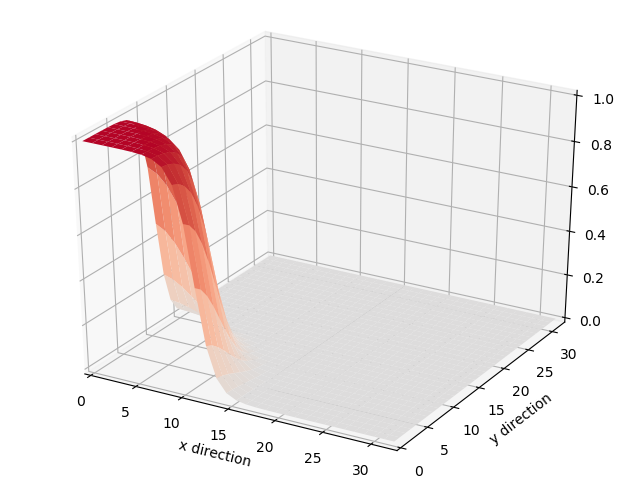

In [8]:
do_timestep(p)

x = np.linspace(0, nx, nx)
y = np.linspace(0, ny, ny)
x, y = np.meshgrid(y, x)

fig = plt.figure()
fig.set_dpi(100)
ax = Axes3D(fig)

def animate(i):
    ax.clear()
    plt.ylim([0,ny])
    plt.xlim([0,nx])
    plt.xlabel('x direction')
    plt.ylabel('y direction')
    ax.plot_surface(x, y, p[i,:,:], rstride=1, cstride=1, cmap=plt.cm.coolwarm,vmax=1,vmin=-1)
    ax.set_zlim(0, 1)
    
anim = animation.FuncAnimation(fig,animate,frames=nsteps-1,interval=10,repeat=False)
plt.show()